In [ ]:
# main.py

import polars as pl
import os
import time

from dataclasses import dataclass
from src.futuapi.futu_api import FutuApi
from src.calculator.mathmatics import add_mean, add_boll

# 设置 Polars 显示的最大行数和列数
# pl.Config.set_tbl_width(1000)  # 设置表格的最大宽度，单位为字符
pl.Config.set_tbl_cols(100)  # 设置显示的最大列数
pl.Config.set_tbl_rows(10)  # 设置显示的最大行数


def parse_df_time(df):
    df = df.with_columns(
        pl.col("time_key").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"),
        pl.col("close").cast(pl.Float64).alias("price"),
    )
    df = df.with_columns(
        [
            pl.col("time_key").dt.date().cast(pl.Utf8).alias("date"),
            pl.col("time_key").dt.time().cast(pl.Utf8).alias("time"),
        ]
    )
    return df


def trans(fund_df: pl.DataFrame, index_df: pl.DataFrame):
    fund_df = (
        parse_df_time(fund_df)
        .filter(pl.col("time") == "14:50:00")
        .select(["date", "price"])
    )
    # print(fund_df)

    index_df = parse_df_time(index_df)
    df_index_vol = (
        index_df.group_by("date")
        .agg([pl.col("volume").sum().alias("volume")])
        .sort("date")
    )
    df_index_check_vol = (
        index_df.filter(pl.col("time") <= "14:50:00")
        .group_by("date")
        .agg([pl.col("volume").sum().alias("check_volume")])
        .sort("date")
    )
    df_index_check_price = (
        index_df.filter(pl.col("time") == "14:50:00")
        .with_columns(pl.col("price").cast(pl.Float64).alias("check_index_price"))
        .select("date", "check_index_price")
    )

    df = (
        index_df.filter(pl.col("time") == "15:00:00")
        .with_columns(pl.col("price").cast(pl.Float64).alias("index_price"))
        .select("date", "index_price")
        .join(df_index_check_vol, on=["date"])
        .join(df_index_vol, on=["date"])
        .join(df_index_check_price, on=["date"])
        .join(fund_df, on=["date"])
    ).select(
        ["date", "check_volume", "volume", "check_index_price", "index_price", "price"]
    )
    df = df.sort("date")
    # print(index_df)
    df = df.with_columns(
        pl.col("index_price").shift(1).rolling_max(window_size=25).alias("max_25")
    )
    df = df.with_columns(
        pl.col("check_volume")
        .shift(1)
        .rolling_mean(window_size=10)
        .cast(pl.Int64)
        .alias("avg_vol_10")
    )

    # df = df.with_columns(pl.col("price").rolling_mean(5).alias(f"ma_5"))
    # df = df.with_columns(pl.col("price").rolling_mean(20).alias(f"ma_20"))
    # df = df.with_columns(pl.col("price").rolling_mean(60).alias(f"ma_60"))
    # df = df.with_columns(pl.col("price").rolling_mean(120).alias(f"ma_120"))

    # df = df.with_columns(
    #     pl.col("price").rolling_min(window_size=5, min_periods=1).alias("min_5")
    # )
    # df = df.with_columns([(pl.col("price") - pl.col("price").shift(5)).alias("del_10")])

    # print(df)

    return df


@dataclass
class FundRecord:
    date: str
    code: str
    price: float
    check_index_price: float
    index_price: float
    check_volume: int
    volume: int
    max_25: float
    avg_vol_10: int


sub_info = [
    {
        "code": "SH.512880",
        "index": "SZ.399975",
    },
    {
        "code": "SH.510300",
        "index": "SH.000300",
    },
    # {
    #     'code': 'SH.510500',
    #     'index': 'SH.000905',
    # },
    {"code": "SH.512100", "index": "SH.000852"},
]


class MarketDataMap:
    def __init__(self):
        self.raw_data = {}
        self.start_date = "2017-01-01"
        self.end_date = "2024-12-02"

    def init_data(self):
        api = FutuApi()
        try:
            for sub_dict in sub_info:
                fund_df = api.get_minute_kline(
                    sub_dict["code"], self.start_date, self.end_date
                )
                index_df = api.get_minute_kline(
                    sub_dict["index"], self.start_date, self.end_date
                )
                df = trans(fund_df, index_df)
                for row in df.iter_rows(named=True):
                    date = row["date"]
                    if date not in self.raw_data:
                        self.raw_data[date] = []
                    record = FundRecord(
                        code=sub_dict["code"],
                        date=row["date"],
                        price=row["price"],
                        check_index_price=row["check_index_price"],
                        index_price=row["index_price"],
                        check_volume=row["check_volume"],
                        volume=row["volume"],
                        max_25=row["max_25"],
                        avg_vol_10=row["avg_vol_10"],
                    )
                    self.raw_data[date].append(record)
        finally:
            api.close()

        # for date, data in self.raw_data.items():
        #     print(date, data)
        #     time.sleep(1)


market_data_map = MarketDataMap()
market_data_map.init_data()

2024-12-03 12:59:51,602 | 58803 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=9, host=127.0.0.1, port=11111, user_id=13389358
Error retrieving trading days: Invalid time period
Trading days saved to /data/futu/A-shares/cfg/trading_days.toml


Processing trading days: 100%|██████████| 221/221 [00:00<00:00, 3269.09it/s]


2024-12-03 12:59:52,139 | 58803 | [open_context_base.py] on_disconnect:383: Disconnected: conn_id=9


max_val: 100000.0, max_drawdone: 0.0, rate: 0.0, has position day: 0, has position rate: 0.0
2024-02-06 sale:  [] buy:  [] val:  100000.0
max_val: 100000.0, max_drawdone: 0.0, rate: 0.0, has position day: 0, has position rate: 0.0
2024-02-07 sale:  [] buy:  [] val:  100000.0
max_val: 100000.0, max_drawdone: 0.0, rate: 0.0, has position day: 0, has position rate: 0.0
2024-02-08 sale:  [] buy:  [] val:  100000.0
max_val: 100000.0, max_drawdone: 0.0, rate: 0.0, has position day: 0, has position rate: 0.0
2024-02-19 sale:  [] buy:  [] val:  100000.0
max_val: 100000.0, max_drawdone: 0.0, rate: 0.0, has position day: 0, has position rate: 0.0
2024-02-20 sale:  [] buy:  [] val:  100000.0
max_val: 100000.0, max_drawdone: -0.049929000000005885, rate: -0.049929000000005885, has position day: 1, has position rate: 16.666666666666668
2024-02-21 sale:  [] buy:  [['SH.512880']] val:  99950.071
100348.4932
max_val: 100348.4932, max_drawdone: -0.049929000000005885, rate: 0.34849320000000716, has posit

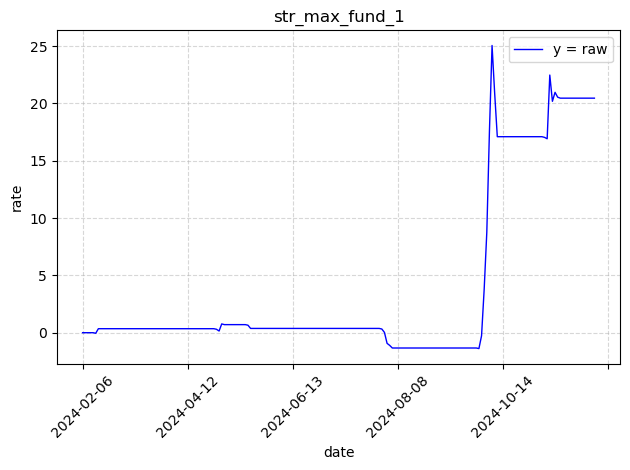

In [43]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def truncate_float(number, t):
    """
    截断浮点数到指定的小数位数，不进行四舍五入。

    :param number: 要截断的浮点数
    :param decimals: 小数位数
    :return: 截断后的浮点数
    """
    factor = 10.0**t
    truncated = math.trunc(number * factor) / factor
    return truncated


def show_rate(x: list, y: list):
    ax = plt.gca()  # 获取当前轴对象
    ax.xaxis.set_major_locator(
        MaxNLocator(integer=True, prune="both", nbins=6)
    )  # 自动选择6个关键点显示
    plt.plot(x, y, linestyle="-", linewidth=1, color="b", label="y = raw")
    # plt.plot(x, py, linestyle="-", linewidth=1, color="r", label="py = main")
    plt.title(f"str_max_fund_1")
    plt.xlabel("date")
    plt.ylabel("rate")
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.5)
    # 显示图例
    plt.legend()

    # 显示图形
    plt.show()


class SecSignal:
    def __init__(self):
        self.on_position = False
        self.price = 0.0
        self.rate = 0.0
        self.max_price = 0.0

    def check(self, record: FundRecord):
        if self.on_position:
            if (
                record.check_index_price <= record.max_25 * 0.95
                or record.check_volume < record.avg_vol_10
            ):
                self.rate = record.price * 100 / self.price - 100
                self.on_position = False
                self.max_price = 0
                return "Sale"
        else:
            if (
                record.check_index_price >= record.max_25
                and record.check_volume > record.avg_vol_10 * 1.2
            ):
                self.price = record.price
                self.on_position = True
                self.max_price = record.price
                return "Buy"
        self.max_price = max(self.max_price, record.price)
        return "None"


class FundAccount:
    def __init__(self):
        self.init = 100000
        self.cash = 100000
        self.position = {}
        self.fee = 0.001
        # self.buys = []
        # self.sales = []
        # self.has_position = 0
        # self.no_position = 0
        self.max_val = 0.0
        self.max_drawdone = 0.0
        self.rate = 0.0

        self.max_val = 0.0
        self.max_drawdone = 0.0

        self.has_position_days = 0
        self.days = 0

    def val(self, records: list):
        result = 0.0
        result += self.cash
        result += sum(
            [
                self.position[record.code] * record.price
                for record in records
                if record.code in self.position
            ]
        )
        return result

    def buy_record(self, deno: int, record: FundRecord):
        t_cash = self.cash / deno
        t_price = record.price * (1 + self.fee)
        cnt = truncate_float(t_cash / t_price, -2)
        self.position[record.code] = cnt
        self.cash -= cnt * t_price

    def buy(self, buy_list: list):
        i = 0
        for deno in range(2, len(self.position), -1):
            if len(buy_list) <= i:
                break
            self.buy_record(deno, buy_list[i][0])
            i += 1

    def sale_record(self, record: FundRecord):
        if record.code not in self.position:
            print(f"err: not find record postion for code {record.code}")
            return
        t_price = record.price * (1.0 - self.fee)
        self.cash += self.position[record.code] * t_price
        print(self.cash)
        del self.position[record.code]

    def sale(self, sale_list: list):
        for [record, rate] in sale_list:
            self.sale_record(record)

    def print_meta(self, records: list):
        val = self.val(records)
        self.days += 1
        if len(self.position) != 0:
            self.has_position_days += 1
        self.max_val = max(self.max_val, val)
        self.max_drawdone = min(self.max_drawdone, val * 100 / self.max_val - 100.0)
        print(
            f"max_val: {self.max_val}, max_drawdone: {self.max_drawdone}, rate: {val * 100 / self.init - 100.0}, has position day: {self.has_position_days}, has position rate: {self.has_position_days * 100 / self.days}"
        )


fund_account = FundAccount()
signals = {}
for sub_dict in sub_info:
    signals[sub_dict["code"]] = SecSignal()

x = []
y = []

for date, records in market_data_map.raw_data.items():
    if records[0].max_25 == None:
        continue
    # print(date, records)
    buy_list = []
    sale_list = []
    for record in records:
        sig = signals[record.code].check(record)
        if sig == "Sale":
            sale_list.append([record, signals[record.code].rate])
        elif sig == "Buy":
            buy_list.append([record])
        # sig_list.append([record.code, sig])

    fund_account.sale(sale_list)
    fund_account.buy(buy_list)
    val = fund_account.val(records)
    fund_account.print_meta(records)
    print(
        date,
        "sale: ",
        [[ele[0].code, ele[1]] for ele in sale_list],
        "buy: ",
        [[ele[0].code] for ele in buy_list],
        "val: ",
        val,
    )

    x.append(date)
    y.append(val * 100 / 100000 - 100.0)

show_rate(x, y)

# time.sleep(1)